# COURSE: A deep understanding of deep learning
## SECTION: Weight inits and investigations
### LECTURE: CodeChallenge: Xavier vs. Kaiming
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/tmp/ipykernel_2311829/649372525.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['boolQuality'][data['quality']>5] = 1
/tmp/ipykernel_2311829/649372525.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [4]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [5]:
# global parameter
numepochs = 600

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Now we create and train the models

In [ ]:
# create the models
winenet_kaiming = ANNwine()
winenet_xavier = ANNwine()

# initialize weights using Kaiming and Xavier
for layer in winenet_kaiming.children():
    if hasattr(layer,'weight'):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')

for layer in winenet_xavier.children():
    if hasattr(layer,'weight'):
        nn.init.xavier_normal_(layer.weight)

# train the models
trainAcc_kaiming,testAcc_kaiming,losses_kaiming = trainTheModel()
trainAcc_xavier,testAcc_xavier,losses_xavier = trainTheModel()


# Visualize the results

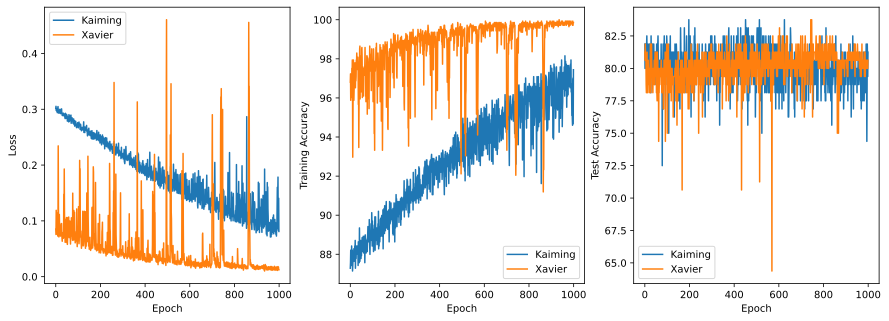

In [12]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(losses_kaiming,label='Kaiming')
ax[0].plot(losses_xavier,label='Xavier')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(trainAcc_kaiming,label='Kaiming')
ax[1].plot(trainAcc_xavier,label='Xavier')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Training Accuracy')
ax[1].legend()

ax[2].plot(testAcc_kaiming,label='Kaiming')
ax[2].plot(testAcc_xavier,label='Xavier')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Test Accuracy')
ax[2].legend()

# Now let's run it 10 times and compare the results better

In [13]:
losses_kaiming = []
trainAcc_kaiming = []
testAcc_kaiming = []

losses_xavier = []
trainAcc_xavier = []
testAcc_xavier = []

for i in range(10):
    winenet_kaiming = ANNwine()
    winenet_xavier = ANNwine()

    for layer in winenet_kaiming.children():
        if hasattr(layer,'weight'):
            nn.init.kaiming_normal_(layer.weight)

    for layer in winenet_xavier.children():
        if hasattr(layer,'weight'):
            nn.init.xavier_normal_(layer.weight)

    trainAccBatch_kaiming,testAccBatch_kaiming,lossesBatch_kaiming = trainTheModel()
    trainAccBatch_xavier,testAccBatch_xavier,lossesBatch_xavier = trainTheModel()

    losses_kaiming.append(lossesBatch_kaiming[-3])
    trainAcc_kaiming.append(trainAccBatch_kaiming[-3])
    testAcc_kaiming.append(testAccBatch_kaiming[-3])

    losses_xavier.append(lossesBatch_xavier[-3])
    trainAcc_xavier.append(trainAccBatch_xavier[-3])
    testAcc_xavier.append(testAccBatch_xavier[-3])

# Measure the t-test differences between the two methods and visualise

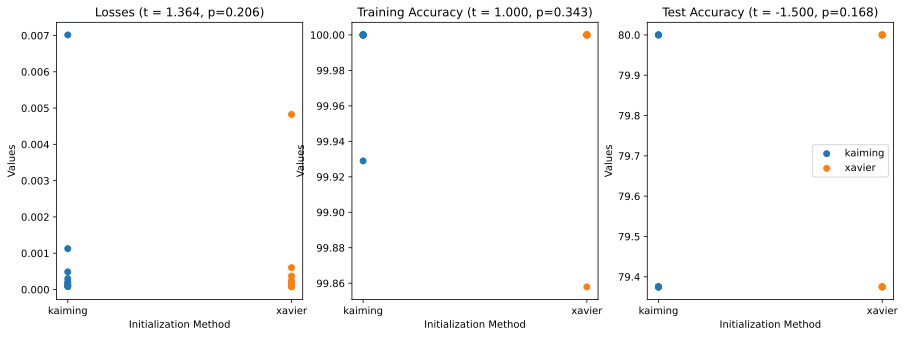

In [29]:
# All of this is wrong
# I've should have stored all the values to compare, but I was only storing
# the last 3 values. So yeah, it doesn't see a difference when there is one.
# Look at the official answer for the correct way to do this.

t_loss,p_loss = stats.ttest_rel(losses_kaiming,losses_xavier)
t_train,p_train = stats.ttest_rel(trainAcc_kaiming,trainAcc_xavier)
t_test,p_test = stats.ttest_rel(testAcc_kaiming,testAcc_xavier)

x_positions_kaiming = np.full(10, 1)  # All points at x=1 for "kaiming"
x_positions_xavier = np.full(10, 2)   # All points at x=2 for "xavier"

fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].scatter(x_positions_kaiming, losses_kaiming, label='kaiming')
ax[0].scatter(x_positions_xavier, losses_xavier, label='xavier')
ax[0].set_xticks([1, 2], ['kaiming', 'xavier'])
ax[0].set_xlabel('Initialization Method')
ax[0].set_ylabel('Values')
ax[0].set_title(f'Losses (t = {t_loss:.3f}, p={p_loss:.3f})')


ax[1].scatter(x_positions_kaiming, trainAcc_kaiming, label='kaiming')
ax[1].scatter(x_positions_xavier, trainAcc_xavier, label='xavier')
ax[1].set_xticks([1, 2], ['kaiming', 'xavier'])
ax[1].set_xlabel('Initialization Method')
ax[1].set_ylabel('Values')
ax[1].set_title(f'Training Accuracy (t = {t_train:.3f}, p={p_train:.3f})')

ax[2].scatter(x_positions_kaiming, testAcc_kaiming, label='kaiming')
ax[2].scatter(x_positions_xavier, testAcc_xavier, label='xavier')
ax[2].set_xticks([1, 2], ['kaiming', 'xavier'])
ax[2].set_xlabel('Initialization Method')
ax[2].set_ylabel('Values')
ax[2].set_title(f'Test Accuracy (t = {t_test:.3f}, p={p_test:.3f})')

# Show legend
plt.legend()

plt.show()